## Filtering the Dataframe properly
1. order msut sum to 45
2. MatchID must be a valid number
3. Lane must be between 1 = 3
4. Hero ID must be between 1 - 138
5. MatchID must be unique and sum to exactly 10

In [ ]:
import pandas as pd
df = pd.read_csv('large_amounts_of_data.csv')

# Keep only the first 10 consecutive rows of each match ID to prevent duplicated data
df_cleaned = df.groupby('MatchID').head(10)

# put the cleaned up data into a new file
df_cleaned.reset_index(drop=True, inplace=True)
df_cleaned.to_csv('cleaned_data.csv', index=False)

df = pd.read_csv("cleaned_data.csv")
# Added in the bracer key late so the early models dont have it but it just means they were 0 so we can just make those values go to zero
df["bracer"].fillna(int(0), inplace=True)

#1. the ordrr must sum to 45
grouped = df.groupby("MatchID")["Order"].sum()
filtered_match_ids = grouped[grouped == 45].index
# Create a new DataFrame with only the rows corresponding to the filtered "MatchID"
df = df[df["MatchID"].isin(filtered_match_ids)]

# 2 and 3 remove the values of the dataframe where the match id is invalid or the lane is biggerr than 3 as this is ambigous and bad data 
cleaned_df = df[(df['MatchID'] > 100000) & (df["Lane"] < 4) & (df["Lane"] > 0)]

#4. hero id's between
cleaned_df = cleaned_df[cleaned_df["Hero ID"].between(1, 138)]

# 5. A valid match id must have exactly 10 matches
matchID_counts = cleaned_df['MatchID'].value_counts()
valid_matchID = matchID_counts[matchID_counts == 10].index
final_df = cleaned_df[cleaned_df["MatchID"].isin(valid_matchID)]
df_cleaned.to_csv('cleaned_data.csv', index=False)

# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', None)
final_df


In [ ]:
final_df["Hero ID"].value_counts()

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming final_df is your dataframe containing the data
# X contains the features, and y contains the target variable
X1 = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer"]]
X2 = final_df[["Hero ID", "Team", "Order",]]
y = final_df["Lane"]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the decision tree model using the training data
decision_tree_model = tree.DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = decision_tree_model.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(predictions, y_test)
print("Accuracy on the test set:", accuracy)

#https://huggingface.co/models?pipeline_tag=tabular-classification&sort=trending

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Assuming final_df is your dataframe containing the data
# X contains the features, and y contains the target variable
X1 = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer"]]
X2 = final_df[["Hero ID", "Team", "Order"]]
y = final_df["Lane"]

# Vary the test train split size from 0.1 to 0.9
split_sizes = np.arange(0.1, 1.0, 0.1)

# Lists to store accuracy values for X1 and X2
accuracy_X1 = []
accuracy_X2 = []

# Iterate through different split sizes
for split_size in split_sizes:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=split_size, random_state=42)

    # Create and fit the decision tree model using the training data
    decision_tree_model = DecisionTreeClassifier()
    decision_tree_model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = decision_tree_model.predict(X_test)

    # Calculate accuracy on the test set and store it
    accuracy_X1.append(accuracy_score(predictions, y_test))

    # Repeat the process for X2
    X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=split_size, random_state=42)
    decision_tree_model.fit(X_train, y_train)
    predictions = decision_tree_model.predict(X_test)
    accuracy_X2.append(accuracy_score(predictions, y_test))

# Plot the results
plt.plot(split_sizes, accuracy_X1, label='Inputs Including Items')
plt.plot(split_sizes, accuracy_X2, label='Inputs Excluding Items')
plt.xlabel('Test Train Split Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy of Decision Tree Model for Varying Inputs")
plt.show()


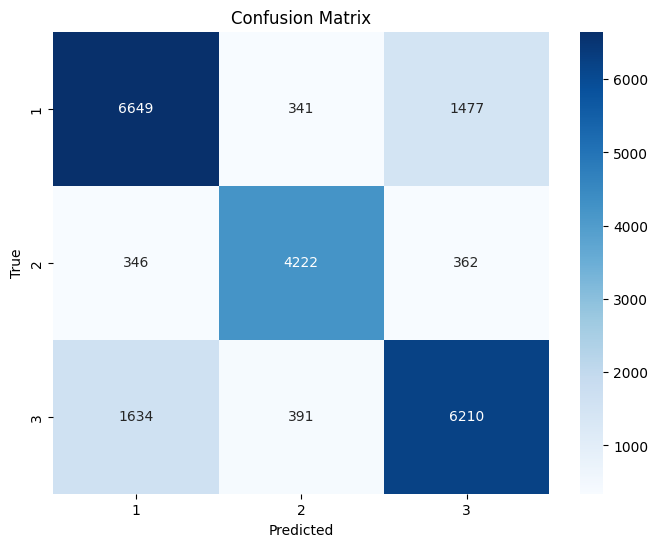

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming final_df is your dataframe containing the data
# ...

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# Create and fit the decision tree model using the training data
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = decision_tree_model.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=decision_tree_model.classes_, yticklabels=decision_tree_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


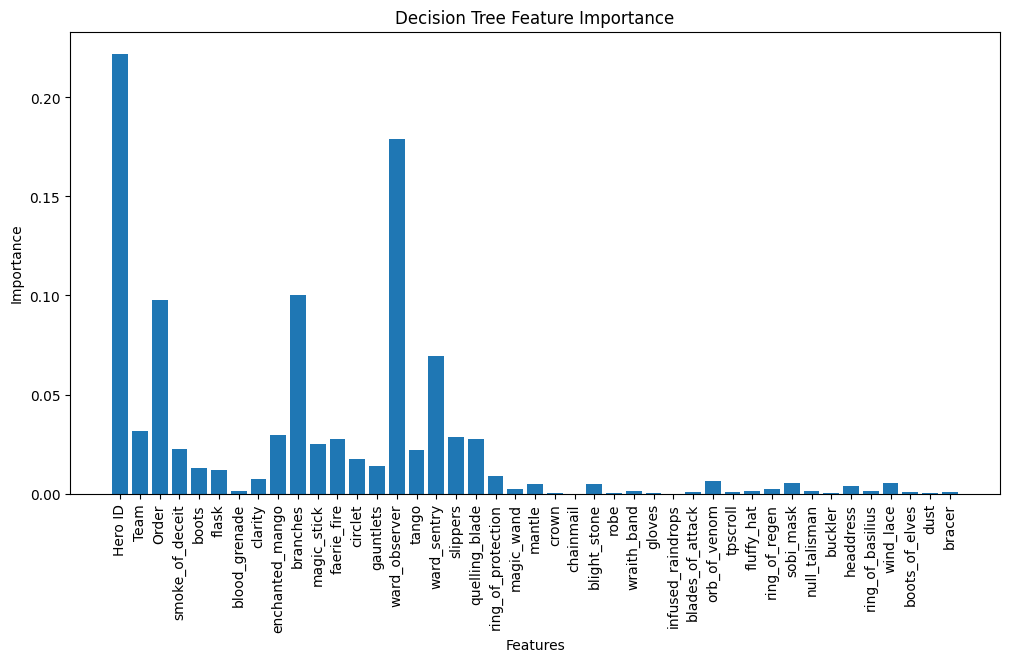

In [11]:
# Assuming final_df is your dataframe containing the data
# ...

# Create and fit the decision tree model using the entire dataset
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X1, y)

# Get feature importances
feature_importances = decision_tree_model.feature_importances_

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(X1.columns, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Decision Tree Feature Importance')
plt.xticks(rotation=90)
plt.show()


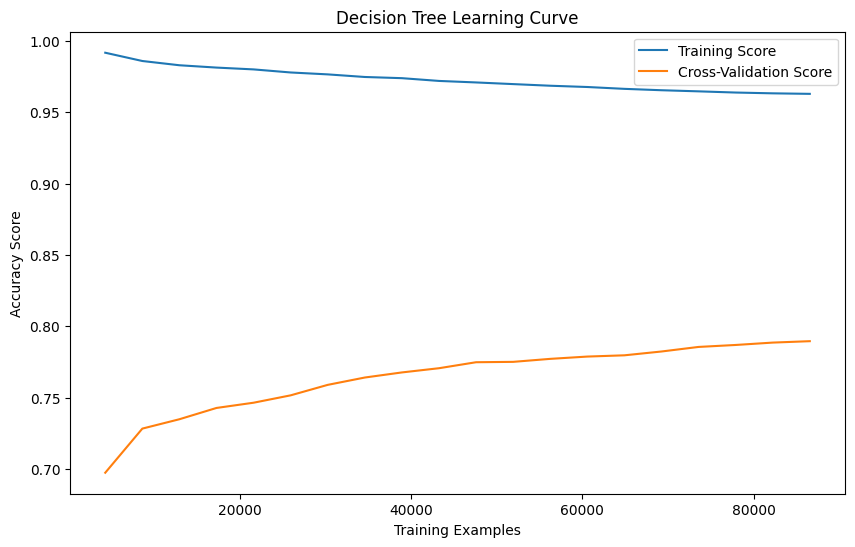

In [13]:
from sklearn.model_selection import learning_curve

# Assuming final_df is your dataframe containing the data
# ...

# Create and fit the decision tree model
decision_tree_model = DecisionTreeClassifier()

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(decision_tree_model, X1, y, cv=5, train_sizes=np.linspace(0.05, 1.0, 20))

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-Validation Score')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy Score')
plt.title('Decision Tree Learning Curve')
plt.legend()
plt.show()


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load your data into a Pandas DataFrame
# Assuming your DataFrame is named df
# You might need to adjust the path or method based on your actual data loading process
# df = pd.read_csv('your_data.csv')

# Prepare your features (X) and target variable (y)
X = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
        "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
        "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
        "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
        "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
        "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer"]]
y = final_df["Lane"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM model
svm_model = SVC(kernel='linear')  # You can use other kernels like 'rbf' or 'poly'
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions = svm_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(predictions, y_test)
print("Accuracy on the test set:", accuracy)


In [ ]:
from fastai.tabular.all import *

splits = RandomSplitter(valid_pct=0.2)(range_of(final_df))
# Load the data
to = TabularPandas(final_df, y_names="Lane",
    cont_names=["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer"])

dls = to.dataloaders(bs=10)
dls.show_batch()
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(1)
learn.show_results()

In [ ]:
def getOrderOnTeam(row):
    match = final_df[final_df["MatchID" == row["MatchID"]] & final_df["Team"== row["Team"]]]
    # sort in descending order
    match = match.sort_values(by = "Order", ascending = False)
    # get the index
    return match["Hero ID" == row["Hero ID"]].index[0]

    
final_df["OrderOnTeam"] = final_df.apply(getOrderOnTeam, axis = 1)

final_df.head(10)
    

final_df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# Adjust column names accordingly

# Scatter plot
sns.scatterplot(x='Order', y='Team', hue='Lane', data=final_df.head(100), palette='viridis')

# Show the plot
plt.show()

# final_df["order_on_team"] = final_df.groupby("MatchID").groupyby("team")[]


## Sanity checks on the Data 

In [ ]:
# #confirmation check that we cleaned properly
result = final_df.groupby("MatchID")["Order"].sum()
result = result.reset_index()
filter = result[result["Order"] != 45]
filter

# final_df["MatchID"].value_counts().sort_values(ascending=True)



If you want to use a neural network with a 10*44 matrix as input instead of a 1-D input vector, you can employ a specific type of neural network architecture known as a "2D Convolutional Neural Network" or "2D CNN." 2D CNNs are well-suited for processing grid-like data such as images or matrices. In your case, where you have a matrix of 10 rows and 44 columns as input for each match, a 2D CNN can be an appropriate choice. 
Please let me know if you have any questions.

## ConvolutionNeural Network for 2D matrix

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create a Sequential model
model = keras.Sequential()

# Add a 2D convolutional layer with 32 filters
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(10, 44, 1)))

# Add a max-pooling layer
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from the previous layer
model.add(layers.Flatten())

# Add a dense (fully connected) layer with 64 units
model.add(layers.Dense(64, activation='relu'))

# Add the output layer with as many units as the number of lane classes
# Adjust the number of units according to your specific problem
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary

model.summary()

In [ ]:
class ConvNetModel(nn.Module):
    def __init__(self, debug=False):
        super(ConvNetModel, self).__init__()
        self.debug = debug

        ### START YOUR CODE ###
        # The first convolutional layer has in_channels=1, out_channels=6, kernel_size=3, with default stride=1 and padding=0
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(10)
        # The first pooling layer is a maxpool with a square window of kernel_size=2 (default stride is same as kernel_size)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # The second convolutional layer
        # NOTE: Its in_channels should match the out_channels of conv1
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=24, kernel_size=3, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(24)
        # The second pooling layer is maxpool with a square window of kernel_size=2
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # The fully-connected layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=24, out_features=10) # Use nn.Linear, and you need to specify the correct in_features and out_features
        
        # Softmax layer
        self.output = nn.LogSoftmax(dim=1) # Use nn.LogSoftmax(), specify the dim correctly
        ### END YOUR CODE ###
        
    
    def forward(self, x):
        # Conv1 -> ReLU -> Batchnorm1-> Pool1
        reluObject = nn.ReLU()
        x = self.conv1(x) 
        x = reluObject(x)
        x = self.bn1(x)
        x = self.pool1(x)

        if self.debug:
            print('output shape of pool1:', x.shape)
        
        ### START YOUR CODE ###
        # Conv2 -> ReLU -> Batchnorm2 -> Pool2
        x = self.conv2(x) 
        x = reluObject(x)
        x = self.bn2(x)
        x = self.pool2(x)
        if self.debug:
            print('output shape of pool2:', x.shape)
        
        # Flatten the output from the last pooling layer
        x = self.flatten(x)
        
        # Call the fully-connected layer, followed by a F.relu()
        x = self.fc(x)
        x = F.relu(x)
        
        # Call softmax layer
        x = self.output(x)
        ### END YOUR CODE ###
        
        return x

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Assuming df is your DataFrame

# Prepare your input data (features)
X = df.iloc[:, 5:].values  # Select columns from 6th to the end (excluding "Lane")
X = X.reshape(-1, 10, 44, 1)  # Reshape to (number_of_samples, 10, 44, 1)

# Prepare your target data (labels)
y = df["Lane"].values.reshape(-1, 1)  # Assuming "Lane" is the target variable

# Perform one-hot encoding on the labels
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and compile the 2D CNN model (as defined in the previous answer)


# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Load your data into a Pandas DataFrame
# Assuming your DataFrame is named df
# You might need to adjust the path or method based on your actual data loading process
# df = pd.read_csv('your_data.csv')

# Extract features and labels
X = df.iloc[:, 5:].values  # Assuming columns from 6th to the end are features
num_heroes = 10
num_features = X.shape[1] // num_heroes
num_matches = len(df['MatchID'].unique())

# Extract features and labels
X = df.iloc[:, 5:].values  # Assuming columns from 6th to the end are features
num_heroes = 10
num_features = X.shape[1] // num_heroes

# Calculate the number of matches based on unique MatchID values
num_matches = len(df['MatchID'].unique())

# Reshape X
X = X.reshape(num_matches, num_heroes, num_features, 1)

# Prepare your target data (labels)
y = df["Lane"].values.reshape(-1, 1)  # Assuming "Lane" is the target variable

# Build the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(num_heroes, num_features, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


In [ ]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)
path.ls()

In [ ]:
df = pd.read_csv(path/'adult.csv')
df.head()


In [ ]:
import pandas as pd

data = {'Age': [30, 35, 25, 40, 32, 28, 45, 22, 38, 33],
        'Income': [50000, 60000, 45000,70000,55000,48000,75000,40000,65000,58000],
        'Loan Approval': ['Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No']}

df = pd.DataFrame(data)
df.sort_values(by='Age')
df.sort_values(by='Income')
